# Time Series Conv1D Algorithm
### 1D convolution layer (temporal convolution)

This algorithm is used to forecast FOREX prices for the EURJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position -1** if the prediction indicates that the price will go down in the next hour

In [38]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import ta
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from UsefulFunctions import data, backtest, display, ai

**Initiating bound between MetaTrader5 and Python**

In [41]:
# To be able to connect to MetaTrader5 you need to be already logged in with your trading account
mt5.initialize()

True

In [43]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("EURJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,145.11,145.17,145.05,145.13,471,40,0
2015-01-02 09:00:00,145.12,145.22,144.95,145.18,953,40,0
2015-01-02 10:00:00,145.19,145.31,144.98,144.98,1448,40,0
2015-01-02 11:00:00,144.97,145.18,144.88,145.18,1298,40,0
2015-01-02 12:00:00,145.17,145.18,145.00,145.12,826,40,0


In [45]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,145.11,145.17,145.05,145.13,471
2015-01-02 09:00:00,145.12,145.22,144.95,145.18,953
2015-01-02 10:00:00,145.19,145.31,144.98,144.98,1448
2015-01-02 11:00:00,144.97,145.18,144.88,145.18,1298
2015-01-02 12:00:00,145.17,145.18,145.00,145.12,826


## Feature engineering 
**Creating new input variables from raw data**

In [48]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,145.13,NaN
2015-01-02 09:00:00,145.18,0.000345
2015-01-02 10:00:00,144.98,-0.001378
2015-01-02 11:00:00,145.18,0.001380
2015-01-02 12:00:00,145.12,-0.000413


In [50]:
# Creating new features to train the model
df_copy2 = df_copy
df_copy2["SMA 15"] = df_copy2[["close"]].rolling(15).mean().shift(1)
df_copy2["SMA 60"] = df_copy2[["close"]].rolling(60).mean().shift(1)
df_copy2["MSD 10"] = df_copy2[["close"]].rolling(10).std().shift(1)
df_copy2["MSD 30"] = df_copy2[["close"]].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df_copy2["close"], window=30, fillna=False)
df_copy2["RSI 30"] = RSI.rsi().shift(1)

WR = ta.momentum.WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=21, fillna=False)
df_copy2["WR 21"] = WR.williams_r().shift(1)

df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21
time,,,,,,,,
2015-01-06 20:00:00,141.24,0.000000,141.808667,143.288500,0.270861,0.533607,30.505035,-89.325843
2015-01-06 21:00:00,141.30,0.000425,141.726667,143.223667,0.241072,0.543703,30.505035,-81.052632
2015-01-06 22:00:00,140.99,-0.002194,141.649333,143.159000,0.248106,0.555235,31.465593,-76.404494
2015-01-06 23:00:00,140.74,-0.001773,141.566667,143.092500,0.287897,0.584874,29.300953,-93.820225
2015-01-07 00:00:00,140.79,0.000355,141.478667,143.018500,0.311163,0.618906,27.710587,-99.473684


In [52]:
# Using the custome function "add_shifted_columns" 5 new columns are added with shifted values from close column
# Refer to the docstring of the "add_shifted_columns" function from the data.py file
df_copy2 = data.add_shifted_columns(df_copy2, 5, "close")
df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21,1_close_bars_ago,2_close_bars_ago,3_close_bars_ago,4_close_bars_ago,5_close_bars_ago
time,,,,,,,,,,,,,
2015-01-07 01:00:00,140.86,0.000497,141.378000,142.946333,0.306893,0.646753,28.513361,-87.922705,140.79,140.74,140.99,141.30,141.24
2015-01-07 02:00:00,140.94,0.000568,141.302667,142.873667,0.273620,0.663392,29.644890,-84.158416,140.86,140.79,140.74,140.99,141.30
2015-01-07 03:00:00,141.32,0.002696,141.266000,142.802667,0.243541,0.660060,30.937298,-79.274611,140.94,140.86,140.79,140.74,140.99
2015-01-07 04:00:00,141.32,0.000000,141.251333,142.740000,0.217227,0.644497,36.655141,-59.585492,141.32,140.94,140.86,140.79,140.74
2015-01-07 05:00:00,141.33,0.000071,141.215333,142.678667,0.233390,0.618170,36.655141,-58.064516,141.32,141.32,140.94,140.86,140.79


## Implementing Machine Learning

In [55]:
# Splitting the data into features and labels for the ML model 
X = df_copy2.iloc[:,2:]
y = df_copy2["pct_change"]

# Data si splitted in training, validation and test datasets
# Refer to the docstring of the "split_data" function from the data.py file
X_train, y_train, X_temp, y_temp = data.split_data(X, y, 70)
X_val, y_val, X_test, y_test = data.split_data(X_temp, y_temp, 50)

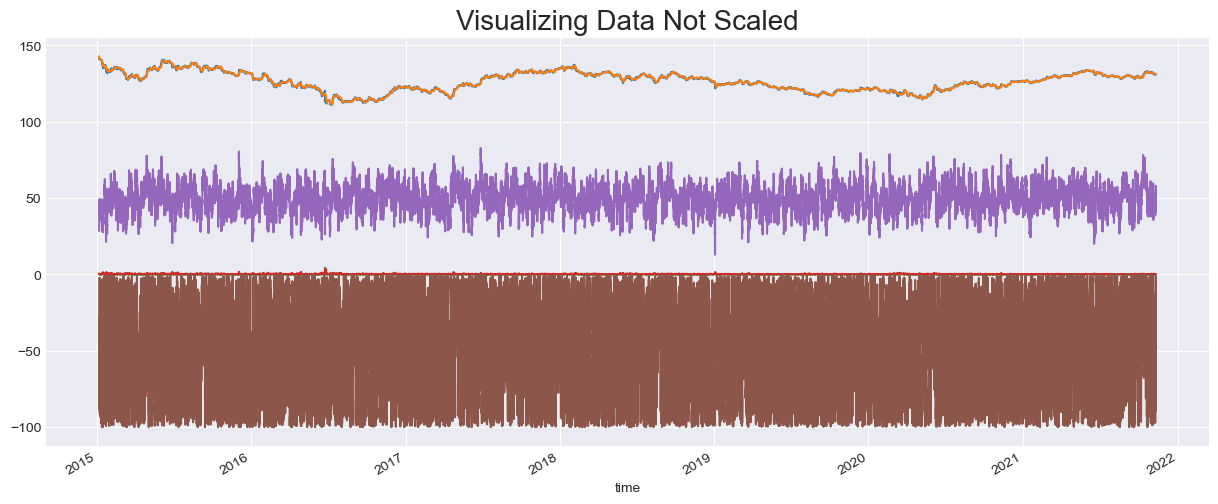

In [57]:
# Plotting features before standardization to visualize their unequal scales
X_train.iloc[:,:6].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Data Not Scaled", fontsize=20)
plt.show()

## Plotting the feature data to assess its distribution and determine if it follows a normal distribution

In [59]:
import seaborn as sns

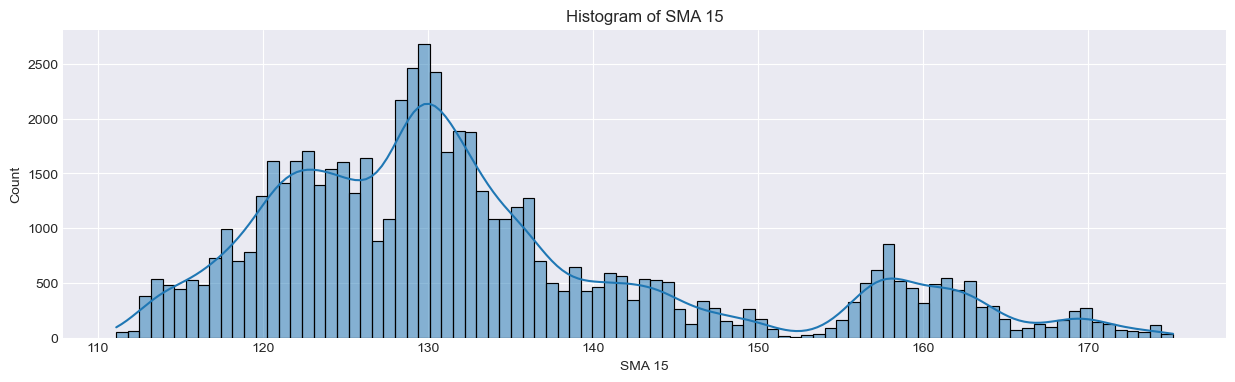

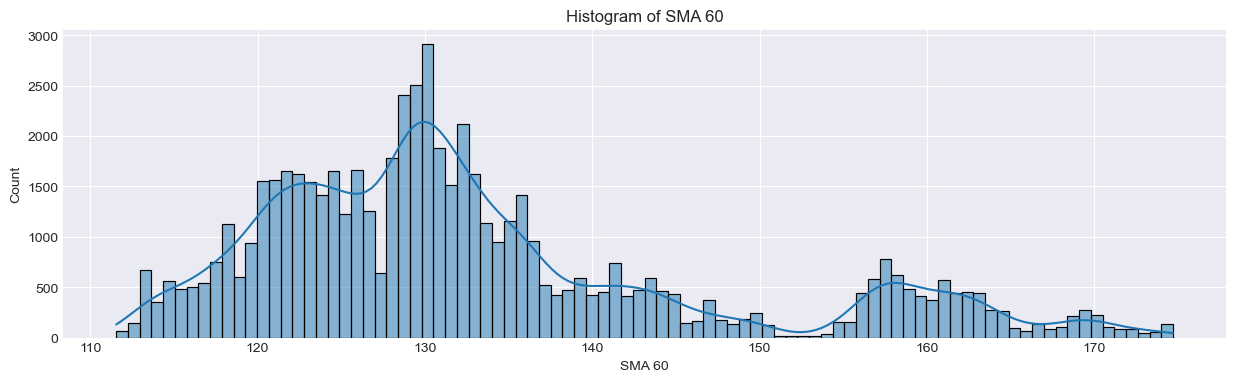

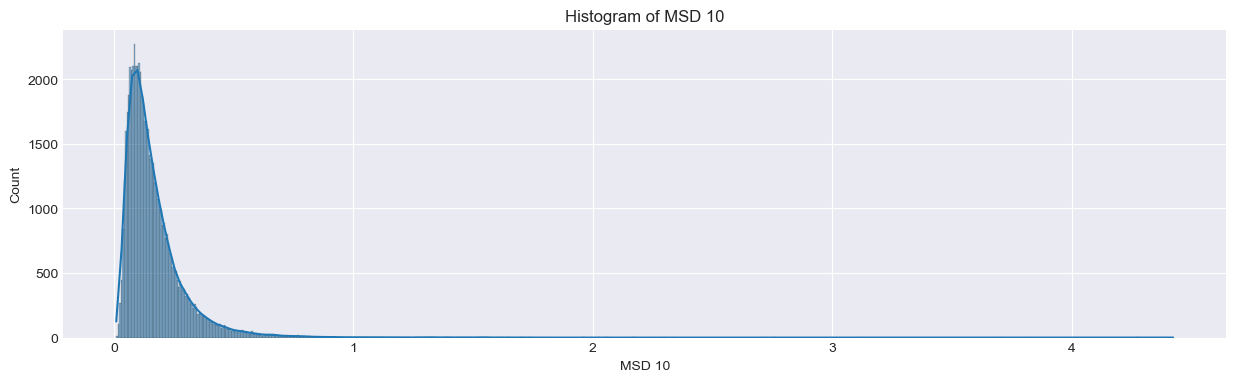

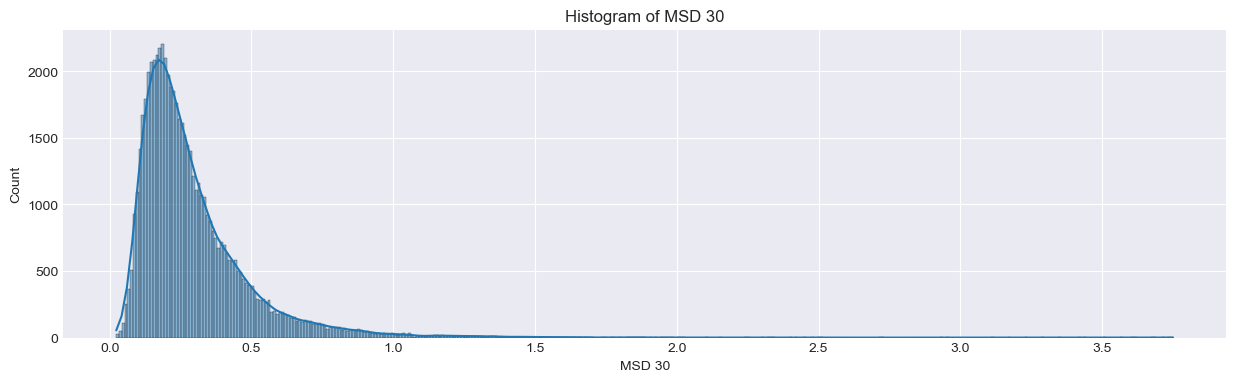

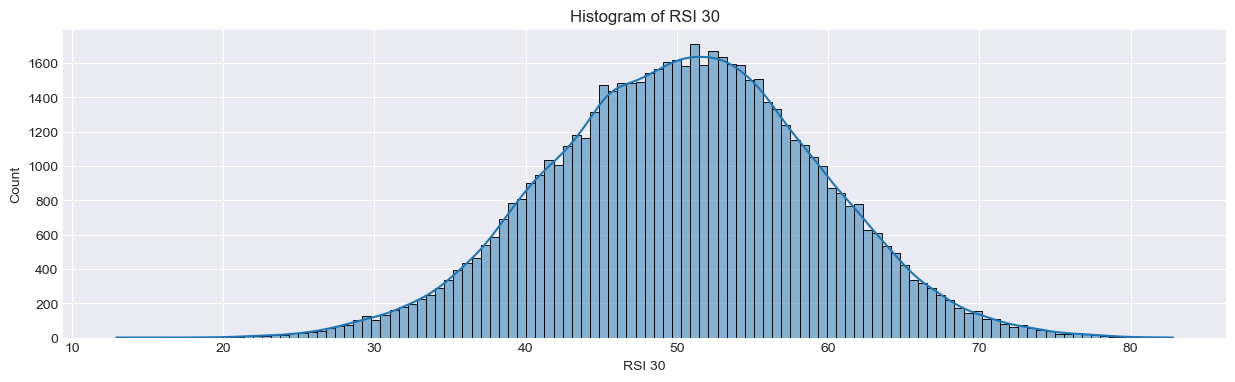

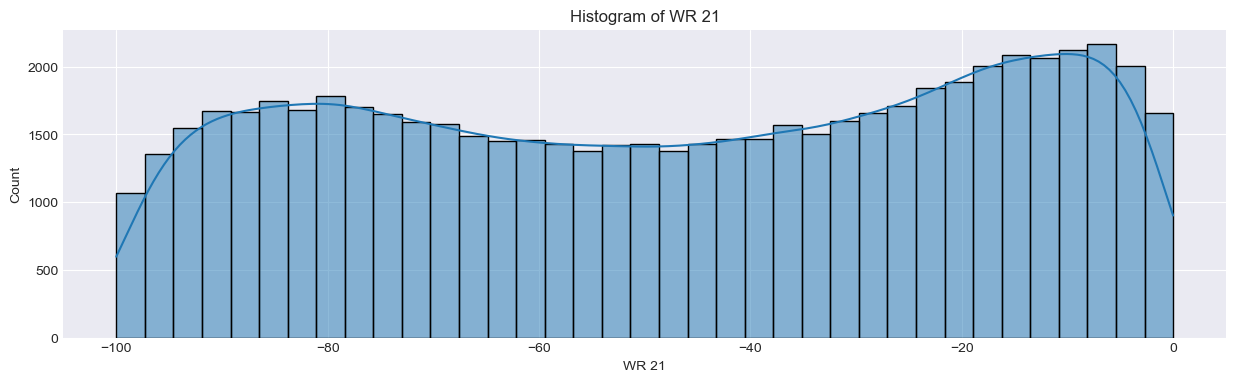

In [61]:
# Plotting a histogram for all features excluding previous bar prices
for col in X_train.iloc[:,:6].columns:
    plt.figure(figsize=(15, 4))
    sns.histplot(df_copy2[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.show()

### Conclusion:
**Most features are not normally distributed, so the appropriate scaler to apply will be MinMaxScaler**

### Applying MinMaxScaler Scaler

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

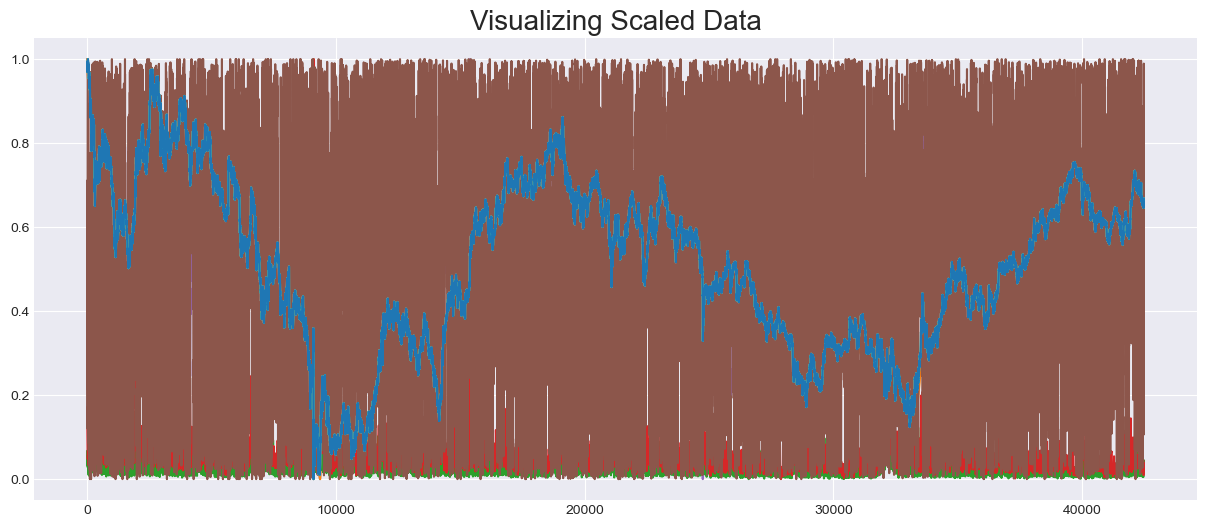

In [70]:
pd.DataFrame(X_train_scaled).plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Scaled Data", fontsize=20)
plt.show()

**Transforming 2D data into 3D datasets**

This is the proper data shape received by the Conv1D Layer|

In [73]:
# Refer to the docstring of the "create_3d_data" function from the data.py file
X_train_3d, y_train_3d = data.create_3d_data(X_train_scaled, np.sign(y_train), 5)
X_val_3d, y_val_3d = data.create_3d_data(X_val_scaled, np.sign(y_val), 5)
X_test_3d, y_test_3d = data.create_3d_data(X_test_scaled, np.sign(y_test), 5)

### Note:

**This model is not focused on classification, but I’ve observed that it performs more accurately when the labels represent the direction of price movements (using values of 1, 0, or -1). In capital markets, these directional signals are crucial for trading, as they reflect the most important aspect—whether the price is moving up, down, or staying flat**

In [76]:
# Showing the new shape of the X_train dataset
print(f"Old shape of X_train dataset    {X_train_scaled.shape}")
print(f"New shape of X_train dataset    {X_train_3d.shape}")

Old shape of X_train dataset    (42489, 11)
New shape of X_train dataset    (42484, 5, 11)


**Showing the first 3D row of the new X 3D dataset**

In [79]:
pd.DataFrame(X_train_3d[0])

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,1.000000,0.067353,0.167317,0.223074,0.120773,0.971042,0.969434,0.977477,0.987452,0.985521
1,0.997511,0.997685,0.059816,0.171782,0.239263,0.158416,0.973295,0.971042,0.969434,0.977477,0.987452
2,0.996299,0.995423,0.053003,0.170888,0.257755,0.207254,0.975869,0.973295,0.971042,0.969434,0.977477
3,0.995815,0.993426,0.047042,0.166712,0.339566,0.404145,0.988095,0.975869,0.973295,0.971042,0.969434
4,0.994625,0.991472,0.050703,0.159649,0.339566,0.419355,0.988095,0.988095,0.975869,0.973295,0.971042


In [81]:
# These are the new labels represented as price directions-
pd.DataFrame(y_test_3d).tail()

,0
9095,-1.0
9096,1.0
9097,1.0
9098,-1.0
9099,-1.0


In [83]:
# Showing original label values
pd.DataFrame(y_test).tail()

,pct_change
time,
2024-10-14 14:00:00,-0.000110
2024-10-14 15:00:00,0.000380
2024-10-14 16:00:00,0.001188
2024-10-14 17:00:00,-0.000043
2024-10-14 18:00:00,-0.000819


**Importing TensorFlow and Required Libraries to Build Conv1D Model**

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
import os

**Prefetching data to make the model run faster**

In [89]:
# Convert both X and y datasets into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_3d, y_train_3d))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_3d, y_val_3d))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_3d, y_test_3d))

# Batch and prefetch
batch_size = 128  
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Building the First Conv1D Model

In [92]:
def run_conv1d(train_sets,
               val_sets,
               model_name,
               p_filters=32,
               p_kernel_size=5,
               p_strides=1,
               hidden_layers=2,
               p_epochs=25,
               dropout=0.20,
               lr=0.001,
               early_stopping_ptn=15,
               reduce_plateau_ptn=5,
               rp_lr=0.5,
               path="model_experiments",
               p_batch_size=256):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break

    model = Sequential(name=model_name)

    # Input Layer
    model.add(Conv1D(name="input_layer_0", filters=p_filters, kernel_size=p_kernel_size, strides=p_strides, padding="causal", 
                    input_shape=features_input_shape, activation="relu"))

    # Hidden Layers
    for i in range(0, hidden_layers):
        model.add(Conv1D(filters=int(p_filters/2), kernel_size=p_kernel_size, activation="relu", name=f"hidden_layer{i}"))
        model.add(Dropout(dropout, name=f"dropput_layer{i}"))

    # Output Layer
    
    model.add(Dense(1, activation="linear", name="output_layer"))

    checkpoint_callback = ai.create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2)

    # Compiling the model
    model.compile(loss="mae", optimizer=Adam(learning_rate=lr), metrics=["mae"])

    # Training the model
    history = model.fit(train_sets,
                       validation_data=val_sets,
                       batch_size=p_batch_size,
                       epochs=p_epochs,
                       verbose=1,
                       callbacks=[checkpoint_callback, early_stopping, reduce_plateau])

    return history

In [101]:
history_model_1 = run_conv1d(train_sets=train_dataset,
                             val_sets=val_dataset,
                             model_name="model_1",
                             p_filters=32,
                             p_kernel_size=2,
                             p_strides=1,
                             hidden_layers=2,
                             lr=0.001,
                             early_stopping_ptn=11,
                             reduce_plateau_ptn=5)

Epoch 1/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.9767 - mae: 0.9767 - val_loss: 0.9798 - val_mae: 0.9798 - learning_rate: 0.0010
Epoch 2/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9795 - mae: 0.9795 - val_loss: 0.9811 - val_mae: 0.9811 - learning_rate: 0.0010
Epoch 3/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9785 - mae: 0.9785 - val_loss: 0.9819 - val_mae: 0.9819 - learning_rate: 0.0010
Epoch 4/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9773 - mae: 0.9773 - val_loss: 0.9833 - val_mae: 0.9833 - learning_rate: 0.0010
Epoch 5/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9768 - mae: 0.9768 - val_loss: 0.9838 - val_mae: 0.9838 - learning_rate: 0.0010
Epoch 6/25
328/332 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9766 - mae: 0.9766
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9767 - mae: 0.9767 - val_loss: 0.9846 - val_mae: 0.9846 - learning_rate: 0.0010
Ep

**Loading the Model and Showing its Architecture**

In [103]:
from tensorflow.keras.models import load_model

In [104]:
model_1 = load_model("model_experiments/model_1.keras")
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Conv1D)          │ (None, 5, 32)          │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer0 (Conv1D)          │ (None, 4, 16)          │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer0 (Dropout)        │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Conv1D)          │ (None, 3, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer1 (Dropout)        │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3, 1)           │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,965 (27.21 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,644 (18.14 KB)

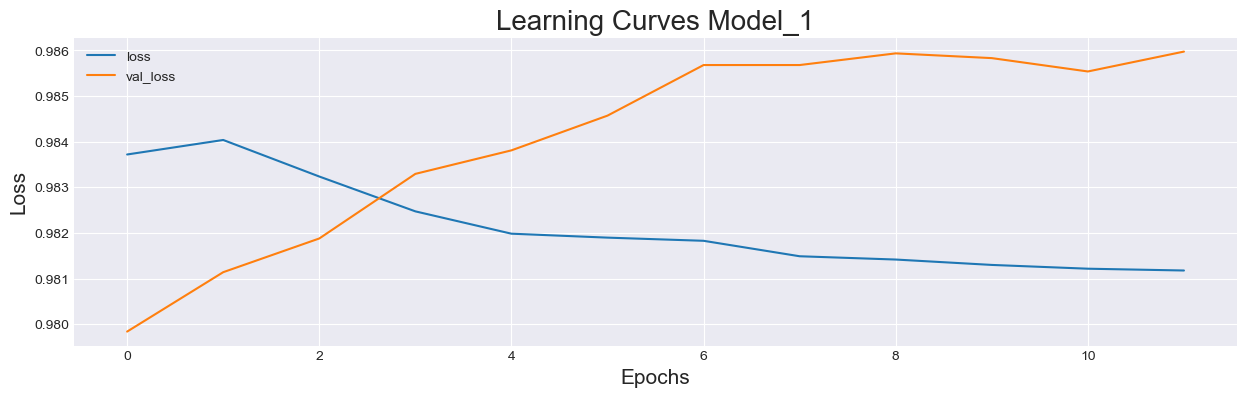

In [105]:
pd.DataFrame(history_model_1.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model_1", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [106]:
# Evaluating the model
model_1.evaluate(test_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9724 - mae: 0.9724


[0.9750369191169739, 0.9750369191169739]

**Making Predictions**

In [108]:
model_1_preds = model_1.predict(X_test_3d)

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [109]:
# Showing the shape of the predictions outcome
model_1_preds.shape

(9100, 3, 1)

In [110]:
np.squeeze(model_1_preds).shape

(9100, 3)

In [111]:
# Showing the first predictions from the model
pd.DataFrame(np.squeeze(model_1_preds))

,0,1,2
0,0.607402,0.577813,0.481883
1,0.562762,0.481883,0.430329
2,0.456736,0.430329,0.448263
3,0.410115,0.448263,0.512825
4,0.420069,0.512825,0.541815
...,...,...,...
9095,0.519974,0.595282,0.639714
9096,0.556481,0.639714,0.653657
9097,0.608331,0.653657,0.653270
9098,0.624463,0.653270,0.653402


In [112]:
# Actual shape of the labels
y_test_3d.shape

(9100,)

**This is Not the desired shape for the predictions outcome**

**Key Insights:** 

- The input data (X_test_3d) has 5 time steps ((9076, 5, 11)), but the label data (y_test_3d) has a shape of (9076, 1).
- However, since Conv1D processes over a time dimension, the model is assuming I am predicting a sequence of outputs (one per time step). The current configuration of the input might be resulting in the model predicting for multiple time steps.
- I am expecting a single output for each input sequence.

**After some research**

I found **GlobalAveragePooling1D** is a layer in TensorFlow that performs global average pooling over the temporal dimensions and is often used after convolutional layers in 1D data to reduce the dimensionality of the data by averaging each feature map across the time dimension.   This reduces the output of the convolutional layers down to a fixed-size vector

### Appying GlobalAveragePooling1D Layer

In [117]:
from tensorflow.keras.layers import GlobalAveragePooling1D

In [118]:
def run_conv1d(train_sets,
               val_sets,
               model_name,
               p_filters=32,
               p_kernel_size=5,
               p_strides=1,
               hidden_layers=2,
               p_epochs=25,
               dropout=0.20,
               lr=0.001,
               early_stopping_ptn=15,
               reduce_plateau_ptn=5,
               rp_lr=0.5,
               path="model_experiments",
               p_batch_size=256):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break

    model = Sequential(name=model_name)

    # Input Layer
    model.add(Conv1D(name="input_layer_0", filters=p_filters, kernel_size=p_kernel_size, strides=p_strides, padding="causal", 
                    input_shape=features_input_shape, activation="relu"))

    # Hidden Layers
    for i in range(0, hidden_layers):
        model.add(Conv1D(filters=int(p_filters/2), kernel_size=p_kernel_size, activation="relu", name=f"hidden_layer{i}"))
        model.add(Dropout(dropout, name=f"dropput_layer{i}"))

    # Applying GlobalAveragePooling1D Layer
    model.add(GlobalAveragePooling1D())
        
    # Output Layer
    model.add(Dense(1, activation="linear", name="output_layer"))

    checkpoint_callback = ai.create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2)

    # Compiling the model
    model.compile(loss="mae", optimizer=Adam(learning_rate=lr), metrics=["mae"])

    # Training the model
    history = model.fit(train_sets,
                       validation_data=val_sets,
                       batch_size=p_batch_size,
                       epochs=p_epochs,
                       verbose=1,
                       callbacks=[checkpoint_callback, early_stopping, reduce_plateau])

    return history

In [119]:
history_model_2 = run_conv1d(train_sets=train_dataset,
                             val_sets=val_dataset,
                             model_name="model_2",
                             p_filters=32,
                             p_kernel_size=2,
                             p_strides=1,
                             hidden_layers=2,
                             lr=0.001,
                             early_stopping_ptn=11,
                             reduce_plateau_ptn=5)

Epoch 1/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.9780 - mae: 0.9780 - val_loss: 0.9826 - val_mae: 0.9826 - learning_rate: 0.0010
Epoch 2/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9828 - mae: 0.9828 - val_loss: 0.9925 - val_mae: 0.9925 - learning_rate: 0.0010
Epoch 3/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9784 - mae: 0.9784 - val_loss: 0.9818 - val_mae: 0.9818 - learning_rate: 0.0010
Epoch 4/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9823 - mae: 0.9823 - val_loss: 0.9906 - val_mae: 0.9906 - learning_rate: 0.0010
Epoch 5/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9788 - mae: 0.9788 - val_loss: 0.9902 - val_mae: 0.9902 - learning_rate: 0.0010
Epoch 6/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9798 - mae: 0.9798 - val_loss: 0.9903 - val_mae: 0.9903 - learning_rate: 0.0010
Epoch 7/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9797 - mae: 0.9797 - val_loss: 0.9892 - val_mae: 0.9892 - learning_rate: 0.0010
Epoch 

**Loading the Model_2 and Showing its Architecture**

In [121]:
model_2 = load_model("model_experiments/model_2.keras")
model_2.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Conv1D)          │ (None, 5, 32)          │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer0 (Conv1D)          │ (None, 4, 16)          │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer0 (Dropout)        │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Conv1D)          │ (None, 3, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer1 (Dropout)        │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,965 (27.21 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,644 (18.14 KB)

**Note**

As we can see, the output_layer now has a single value, which is achieved by using the GlobalAveragePooling1D layer

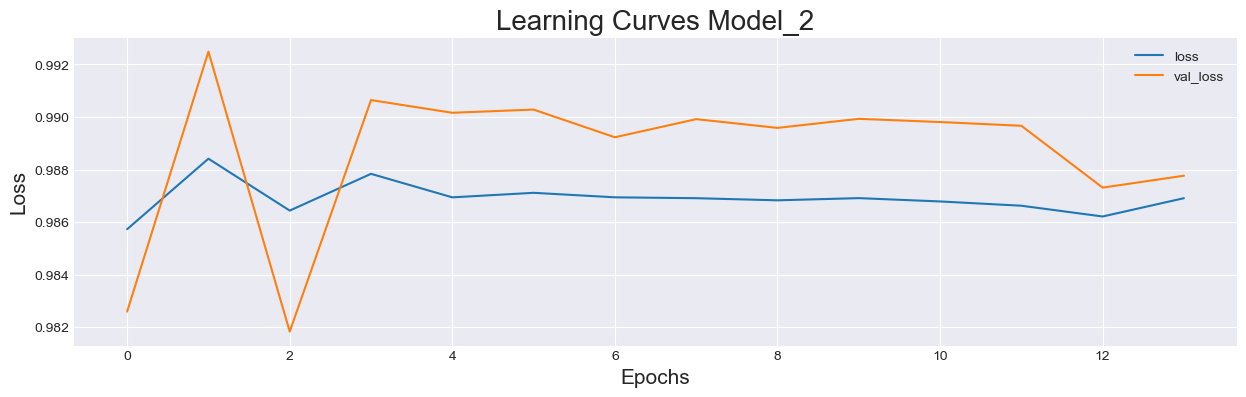

In [123]:
pd.DataFrame(history_model_2.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model_2", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [124]:
# Evaluating the model
model_2.evaluate(test_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9723 - mae: 0.9723


[0.9748823642730713, 0.9748823642730713]

**Making Predictions**

In [126]:
model_2_preds = model_2.predict(X_test_3d)
model_2_preds.shape

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(9100, 1)

In [127]:
# Showing the model_2 predictions in a DataFrame
pd.DataFrame(np.squeeze(model_2_preds))

,0
0,0.603541
1,0.584862
2,0.572266
3,0.572611
4,0.579850
...,...
9095,0.708292
9096,0.718012
9097,0.724717
9098,0.726186


In [128]:
# Showing the directions of the predictions
pd.DataFrame(np.sign(model_2_preds)).value_counts()

0  
1.0    9100
Name: count, dtype: int64

**Note:**

Further tuning of the model's parameters is needed, as we can observe overfitting and that the model is forecasting only positive values.

### After tuning and testing several combination of hyperparameters in a separate branch...

- **Set the parametes the parameters as follows and**
- **Implemented kernel_regularizer**

In [131]:
from tensorflow.keras.regularizers import l2

**Function with new settings**

In [133]:
def run_conv1d(train_sets,
               val_sets,
               model_name,
               p_filters=32,
               p_kernel_size=5,
               p_strides=1,
               hidden_layers=2,
               p_epochs=25,
               dropout=0.20,
               lr=0.001,
               early_stopping_ptn=15,
               reduce_plateau_ptn=5,
               rp_lr=0.5,
               path="model_experiments",
               p_batch_size=256,
               kr_l2=0.1,
               verbose=0):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break

    model = Sequential(name=model_name)

    # Input Layer
    model.add(Conv1D(name="input_layer_0", filters=p_filters, kernel_size=p_kernel_size, strides=p_strides, padding="causal", 
                    input_shape=features_input_shape, activation="relu", kernel_regularizer=l2(kr_l2)))

    # Hidden Layers
    for i in range(0, hidden_layers):
        model.add(Conv1D(filters=int(p_filters/2), kernel_size=p_kernel_size, activation="relu", kernel_regularizer=l2(kr_l2), name=f"hidden_layer{i}"))
        model.add(Dropout(dropout, name=f"dropput_layer{i}"))

    # Applying GlobalAveragePooling1D Layer
    model.add(GlobalAveragePooling1D())
        
    # Output Layer
    model.add(Dense(1, activation="linear", name="output_layer"))

    checkpoint_callback = ai.create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=verbose)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=verbose)

    # Compiling the model
    model.compile(loss="mae", optimizer=Adam(learning_rate=lr), metrics=["mae"])

    # Training the model
    history = model.fit(train_sets,
                       validation_data=val_sets,
                       batch_size=p_batch_size,
                       epochs=p_epochs,
                       verbose=verbose,
                       callbacks=[checkpoint_callback, early_stopping, reduce_plateau])

    return history

In [155]:
history_model_3 = run_conv1d(train_sets=train_dataset,
                             val_sets=val_dataset,
                             model_name="model_3",
                             p_filters=8,
                             p_kernel_size=2,
                             p_strides=4,
                             hidden_layers=1,
                             p_epochs=5,
                             lr=0.0001,
                             early_stopping_ptn=3,
                             reduce_plateau_ptn=2,
                             kr_l2=0.05)

**Model_3 Architecture**

In [157]:
model_3 = load_model("model_experiments/model_3.keras")
model_3.summary()

Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Conv1D)          │ (None, 2, 8)           │           184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer0 (Conv1D)          │ (None, 1, 4)           │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer0 (Dropout)        │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773 (3.02 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 516 (2.02 KB)

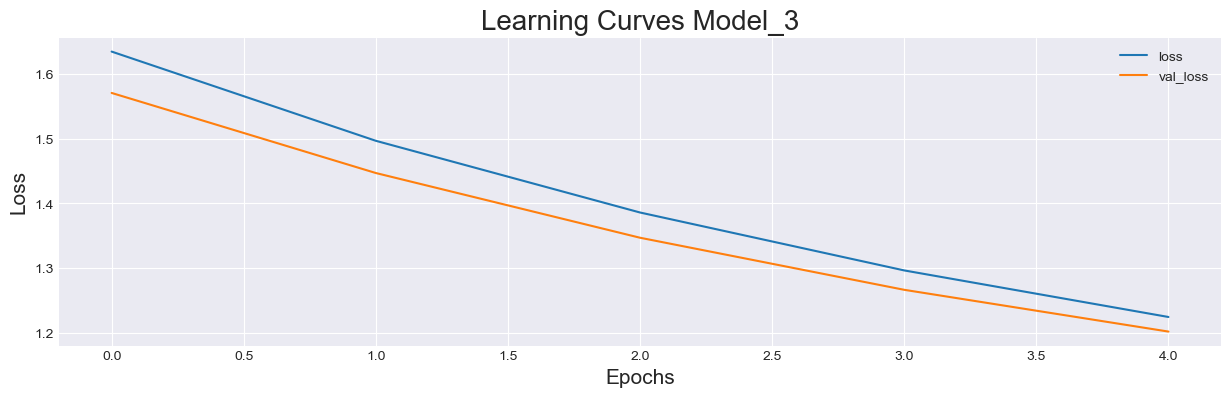

In [160]:
pd.DataFrame(history_model_3.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model_3", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [162]:
# Evaluating the model_3
model_3.evaluate(test_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2025 - mae: 0.9957 


[1.2032079696655273, 0.9963774681091309]

**Making predictions for Model 3**

In [165]:
model_3_preds = model_3.predict(X_test_3d)
model_3_preds.shape

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(9100, 1)

In [167]:
# Showing the model predictions
pd.DataFrame(model_3_preds)

,0
0,0.002158
1,0.003809
2,0.006260
3,0.006816
4,0.009133
...,...
9095,-0.009447
9096,-0.008618
9097,-0.011864
9098,-0.011877


**Note:**

We now see the model has started forecasting prices in both directions

In [170]:
# Count of model forecasted price directions
pd.DataFrame(np.sign(model_3_preds)).value_counts()

0   
-1.0    8193
 1.0     907
Name: count, dtype: int64

**Computing returns for Model 3**

In [173]:
returns_model_3 = backtest.compute_strategy_returns(y_test[5:], model_3_preds)
returns_model_3.head()

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2023-04-27 16:00:00,0.001201,0.002158,1.0,1.0,0.001201
2023-04-27 17:00:00,0.000230,0.003809,1.0,1.0,0.000230
2023-04-27 18:00:00,-0.000061,0.006260,-1.0,1.0,-0.000061
2023-04-27 19:00:00,-0.001063,0.006816,-1.0,1.0,-0.001063
2023-04-27 20:00:00,0.001024,0.009133,1.0,1.0,0.001024


**Plotting the Cumulative Returns from Model 3**

Profits : -10.94%


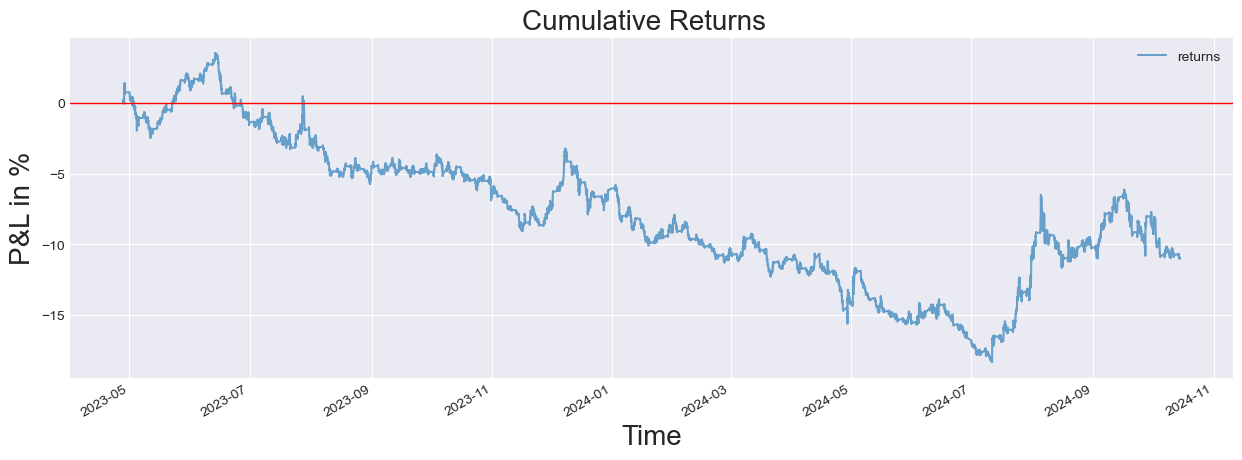

In [176]:
display.plot_test_returns(returns_model_3["returns"])

**Confusion Matrix**

 It provides a detailed breakdown of the model's predictions, showing true positives, true negatives, false positives, and false negatives, which can be used to calculate metrics like accuracy and precision

In [179]:
from sklearn.metrics import confusion_matrix

In [181]:
confusion_matrix(returns_model_3["real_position"], returns_model_3["pred_position"])

array([[3927,    0,  447],
       [  34,    0,    2],
       [4232,    0,  458]], dtype=int64)

**Model 3 Analysis of Accuracy**

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
0    4715
1    4385
Name: count, dtype: int64

Model has an accuracy of: 48.19%


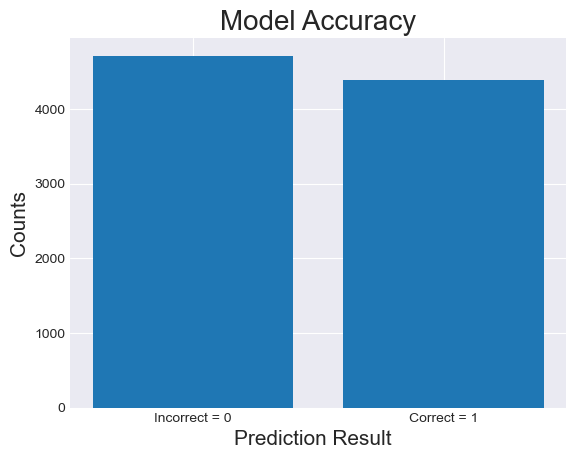

,real_position,pred_position,accuracy
time,,,
2023-04-27 16:00:00,1.0,1.0,1
2023-04-27 17:00:00,1.0,1.0,1
2023-04-27 18:00:00,-1.0,1.0,0
2023-04-27 19:00:00,-1.0,1.0,0
2023-04-27 20:00:00,1.0,1.0,1


In [184]:
backtest.compute_model_accuracy(returns_model_3["real_position"], returns_model_3["pred_position"])

## Running 100 Models

- This helps to mitigate the effects of random weight initialization and stochastic training processes.
- With this, an ensemble model will be created using bagging, which improves generalization.

In [187]:
from tqdm import tqdm

In [201]:
models_history = []
for i in tqdm(range(100)):
    history_model = run_conv1d(train_sets=train_dataset,
                               val_sets=val_dataset,
                               model_name=f"model_{i}",
                               p_filters=8,
                               p_kernel_size=2,
                               p_strides=4,
                               hidden_layers=1,
                               p_epochs=5,
                               lr=0.0001,
                               early_stopping_ptn=3,
                               reduce_plateau_ptn=2,
                               kr_l2=0.05,
                               path="100_model_experiments")
    models_history.append(history_model)

100%|██████████| 100/100 [08:15<00:00,  4.95s/it]


**Plotting the learning curve for one of the models**

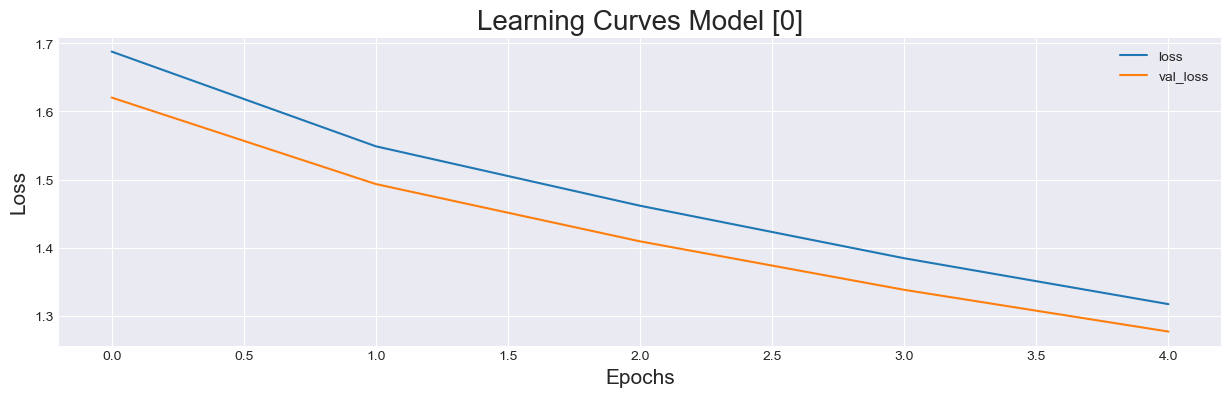

In [205]:
pd.DataFrame(models_history[0].history)[["loss","val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model [0]", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

**Making Predictions on the 100 Models to Identify the Top 5 Best-performing**

In [222]:
positions_df = pd.DataFrame()
returns_df = pd.DataFrame(y_test[5:], columns=["pct_change"])

for i in tqdm(range(100)):
    model_name = f"model_{i}"
    model = load_model(f"100_model_experiments/{model_name}.keras")
    predictions = np.squeeze(model.predict(X_test_3d))
    positions_df[f"position_test_{i}"] = np.sign(predictions)
    returns_df[f"returns_test_{i}"] = returns_df["pct_change"] * np.sign(predictions)

returns_df.drop("pct_change", axis=1, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 1/100 [00:00<01:00,  1.64it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  2%|▏         | 2/100 [00:01<00:57,  1.69it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  3%|▎         | 3/100 [00:01<00:55,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▍         | 4/100 [00:02<00:55,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  5%|▌         | 5/100 [00:02<00:54,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  6%|▌         | 6/100 [00:03<00:53,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  7%|▋         | 7/100 [00:04<00:53,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 8/100 [00:04<00:52,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  9%|▉         | 9/100 [00:05<00:52,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|█         | 10/100 [00:05<00:53,  1.69it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 11%|█         | 11/100 [00:06<00:52,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 12%|█▏        | 12/100 [00:06<00:50,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 13%|█▎        | 13/100 [00:07<00:49,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▍        | 14/100 [00:08<00:49,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 15%|█▌        | 15/100 [00:08<00:48,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 16/100 [00:09<00:47,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 17%|█▋        | 17/100 [00:09<00:47,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 18/100 [00:10<00:47,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 19%|█▉        | 19/100 [00:10<00:46,  1.72it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|██        | 20/100 [00:11<00:45,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 21/100 [00:12<00:45,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 22%|██▏       | 22/100 [00:12<00:44,  1.76it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 23/100 [00:13<00:43,  1.77it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 24%|██▍       | 24/100 [00:13<00:43,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 25%|██▌       | 25/100 [00:14<00:44,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 26%|██▌       | 26/100 [00:15<00:44,  1.68it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 27%|██▋       | 27/100 [00:15<00:43,  1.68it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 28%|██▊       | 28/100 [00:16<00:42,  1.68it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 29%|██▉       | 29/100 [00:16<00:41,  1.69it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 30%|███       | 30/100 [00:17<00:40,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███       | 31/100 [00:17<00:40,  1.72it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 32/100 [00:18<00:39,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 33/100 [00:19<00:39,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 34/100 [00:19<00:38,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 35/100 [00:20<00:37,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 36/100 [00:20<00:37,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 37/100 [00:21<00:37,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 38/100 [00:22<00:36,  1.72it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 39/100 [00:22<00:36,  1.69it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 40/100 [00:23<00:35,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 41/100 [00:23<00:34,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 42/100 [00:24<00:33,  1.76it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 43/100 [00:24<00:32,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 44/100 [00:25<00:31,  1.77it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 45/100 [00:26<00:31,  1.77it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 46/100 [00:26<00:30,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 47/100 [00:27<00:30,  1.76it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 48/100 [00:27<00:29,  1.78it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 49/100 [00:28<00:28,  1.79it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 50/100 [00:28<00:27,  1.80it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 51/100 [00:29<00:27,  1.79it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 52/100 [00:29<00:27,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 53/100 [00:30<00:27,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 54/100 [00:31<00:27,  1.66it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▌    | 55/100 [00:31<00:27,  1.67it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 56/100 [00:32<00:25,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 57/100 [00:33<00:25,  1.68it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 58/100 [00:33<00:24,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 59/100 [00:34<00:24,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 60%|██████    | 60/100 [00:34<00:23,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 61/100 [00:35<00:22,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 62%|██████▏   | 62/100 [00:35<00:21,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 63/100 [00:36<00:21,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 64%|██████▍   | 64/100 [00:37<00:22,  1.60it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▌   | 65/100 [00:37<00:21,  1.61it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▌   | 66/100 [00:38<00:21,  1.58it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 67/100 [00:39<00:20,  1.62it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 68%|██████▊   | 68/100 [00:39<00:19,  1.65it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 69/100 [00:40<00:18,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 70%|███████   | 70/100 [00:40<00:17,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████   | 71/100 [00:41<00:16,  1.72it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 72%|███████▏  | 72/100 [00:41<00:16,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 73/100 [00:42<00:15,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 74%|███████▍  | 74/100 [00:43<00:14,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▌  | 75/100 [00:43<00:14,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 76%|███████▌  | 76/100 [00:44<00:13,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 77%|███████▋  | 77/100 [00:44<00:13,  1.76it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 78%|███████▊  | 78/100 [00:45<00:12,  1.76it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 79%|███████▉  | 79/100 [00:45<00:12,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|████████  | 80/100 [00:46<00:11,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 81%|████████  | 81/100 [00:47<00:11,  1.66it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 82/100 [00:47<00:11,  1.60it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 83/100 [00:48<00:10,  1.59it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 84%|████████▍ | 84/100 [00:49<00:09,  1.63it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 85%|████████▌ | 85/100 [00:49<00:08,  1.67it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 86%|████████▌ | 86/100 [00:50<00:08,  1.70it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 87%|████████▋ | 87/100 [00:50<00:07,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 88/100 [00:51<00:06,  1.72it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 89%|████████▉ | 89/100 [00:51<00:06,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 90%|█████████ | 90/100 [00:52<00:05,  1.71it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 91%|█████████ | 91/100 [00:53<00:05,  1.73it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 92%|█████████▏| 92/100 [00:53<00:04,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 93/100 [00:54<00:03,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 94%|█████████▍| 94/100 [00:54<00:03,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 95%|█████████▌| 95/100 [00:55<00:02,  1.76it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 96%|█████████▌| 96/100 [00:55<00:02,  1.75it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 97%|█████████▋| 97/100 [00:56<00:01,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 98%|█████████▊| 98/100 [00:57<00:01,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 99%|█████████▉| 99/100 [00:57<00:00,  1.74it/s]

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


**DataFrame with all Predictions Converted to Positions (directions)**

In [225]:
positions_df.head()

,position_test_0,position_test_1,position_test_2,position_test_3,position_test_4,position_test_5,position_test_6,position_test_7,position_test_8,position_test_9,...,position_test_90,position_test_91,position_test_92,position_test_93,position_test_94,position_test_95,position_test_96,position_test_97,position_test_98,position_test_99
0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
1,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
2,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
3,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**DataFrame with Returns from all Model Predictions**

In [228]:
returns_df.head()

,returns_test_0,returns_test_1,returns_test_2,returns_test_3,returns_test_4,returns_test_5,returns_test_6,returns_test_7,returns_test_8,returns_test_9,...,returns_test_90,returns_test_91,returns_test_92,returns_test_93,returns_test_94,returns_test_95,returns_test_96,returns_test_97,returns_test_98,returns_test_99
time,,,,,,,,,,,,,,,,,,,,,
2023-04-27 16:00:00,0.001201,0.001201,0.001201,0.001201,-0.001201,0.001201,0.001201,-0.001201,0.001201,0.001201,...,0.001201,-0.001201,0.001201,0.001201,0.001201,0.001201,0.001201,0.001201,0.001201,-0.001201
2023-04-27 17:00:00,0.000230,0.000230,0.000230,0.000230,-0.000230,0.000230,0.000230,-0.000230,0.000230,0.000230,...,-0.000230,-0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,-0.000230,-0.000230
2023-04-27 18:00:00,-0.000061,-0.000061,-0.000061,-0.000061,0.000061,-0.000061,-0.000061,0.000061,-0.000061,-0.000061,...,0.000061,0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,0.000061
2023-04-27 19:00:00,-0.001063,-0.001063,-0.001063,-0.001063,0.001063,-0.001063,-0.001063,0.001063,-0.001063,-0.001063,...,0.001063,0.001063,-0.001063,-0.001063,-0.001063,-0.001063,-0.001063,-0.001063,-0.001063,-0.001063
2023-04-27 20:00:00,0.001024,0.001024,0.001024,0.001024,-0.001024,0.001024,0.001024,-0.001024,0.001024,0.001024,...,-0.001024,-0.001024,0.001024,0.001024,0.001024,0.001024,0.001024,0.001024,0.001024,0.001024


**Plotting the Returns Obtained for all 100 Models**

Profits : 561.18%


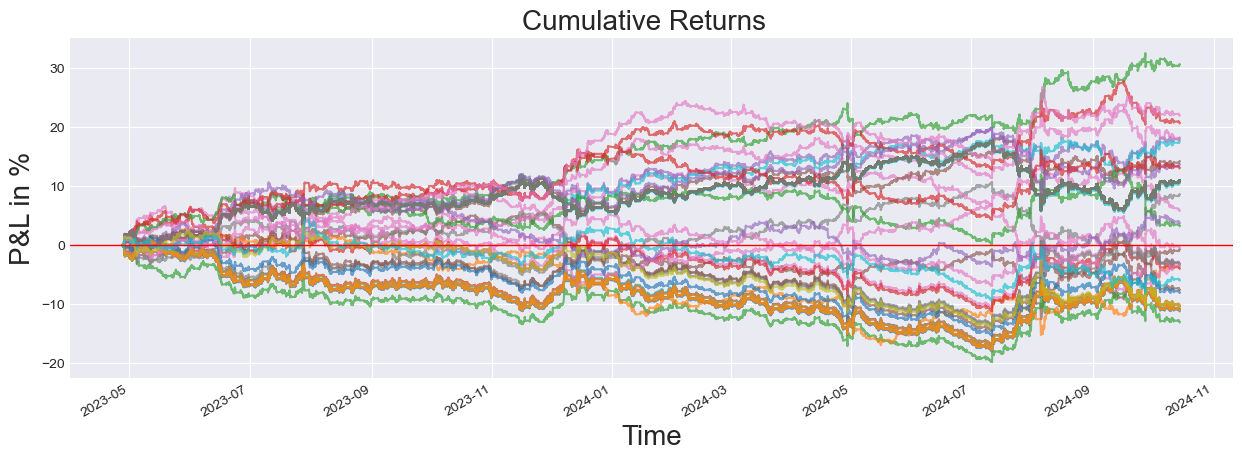

In [231]:
display.plot_test_returns(returns_df, False)

## Analysis to find out what are the 5 best well rounded performing model

**Here, the returns in the "returns_df" are split into two separate sets: one for testing and the other for validation.**

The idea is to find the 5 models that perform the best on the test set, and then evaluate whether they continue to perform well on the second half (the validation set). If they do, this indicates good generalization.

In [235]:
# Splitting the returns into test and validation sets to evaluate generalization
test_split = int(0.50 * len(returns_df))

test_returns = returns_df.iloc[:test_split]
val_returns = returns_df.iloc[test_split:]

**Dataframe with key performing results**

In [238]:
# Refer to the docstrings for the "compute_drawdown" function in the backtest.py file
values = pd.DataFrame(index=["returns", "drawdown", "returns/drawdown"])

for column in test_returns.columns:
    returns_on_test, drawdown_on_test = test_returns[column].cumsum().iloc[-1], -np.min(backtest.compute_drawdown(test_returns[column]))
    values[column] = returns_on_test, drawdown_on_test, returns_on_test/drawdown_on_test

In [240]:
values.transpose().sort_values(by="returns/drawdown", ascending=False).head()

,returns,drawdown,returns/drawdown
returns_test_83,0.187943,0.031583,5.950827
returns_test_96,0.210480,0.038140,5.518683
returns_test_62,0.172817,0.032388,5.335766
returns_test_93,0.141870,0.032388,4.380268
returns_test_54,0.127220,0.037542,3.388764


**Plotting the returns from the Top 5 best performing model based on "returns/drawdown" metric on the "test_returns" dataset**

Profits : 84.03%


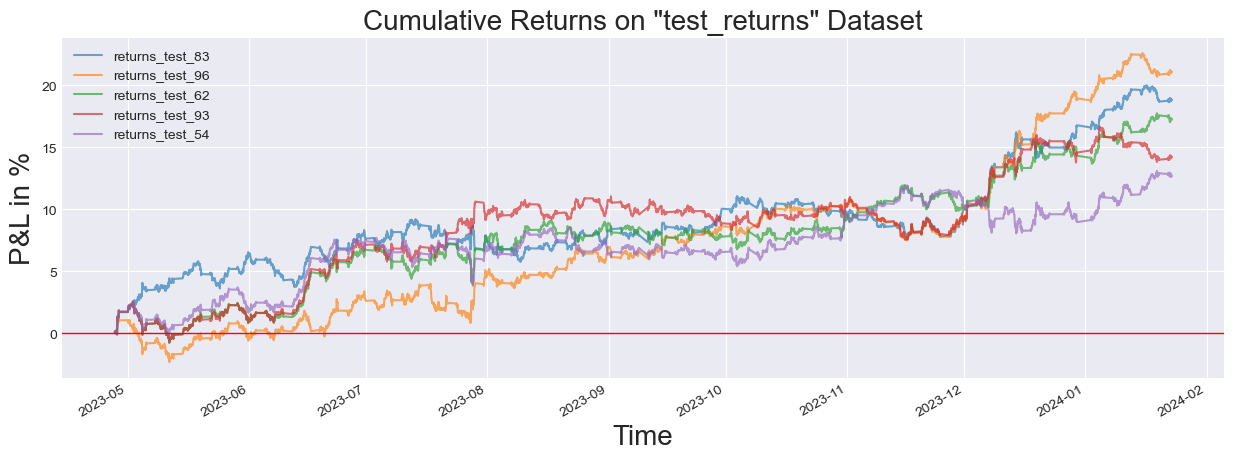

In [256]:
display.plot_test_returns(test_returns[["returns_test_83","returns_test_96","returns_test_62","returns_test_93","returns_test_54"]],
                         name='on "test_returns" Dataset')

**Plotting the returns from the Top 5 best performing model based on "returns/drawdown" metric on the "val_returns" dataset**

This will show if the models that perform well on the test sets will continue to perform well on new unseen data (validation dataset)

Profits : 20.64%


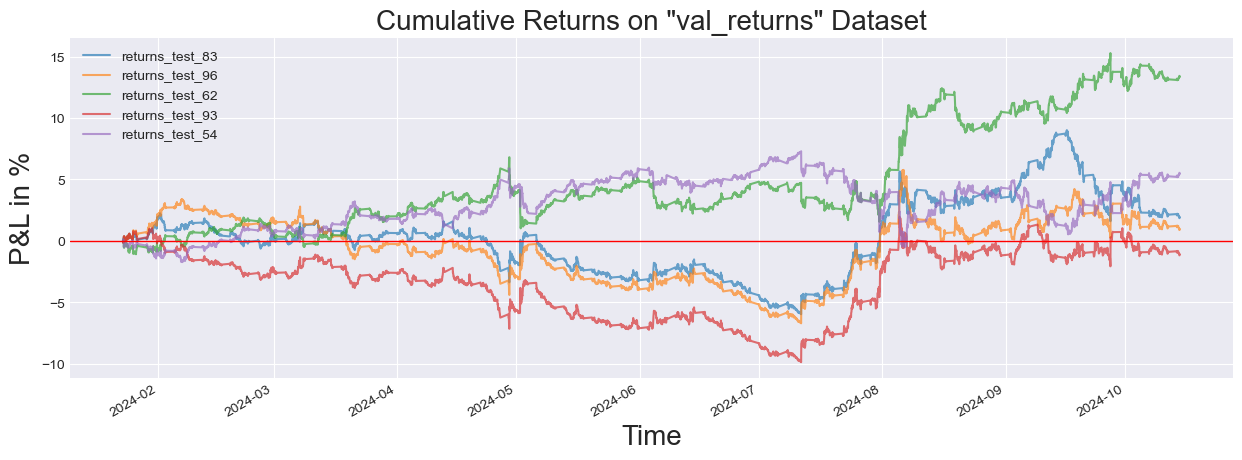

In [260]:
display.plot_test_returns(val_returns[["returns_test_83","returns_test_96","returns_test_62","returns_test_93","returns_test_54"]],
                         name='on "val_returns" Dataset')

**The best performing model on both Test and Validation datasets based on returns/drawdown metric is the model 62**

Plotting the returns obtained with **Molel_62**

Profits : 30.63%


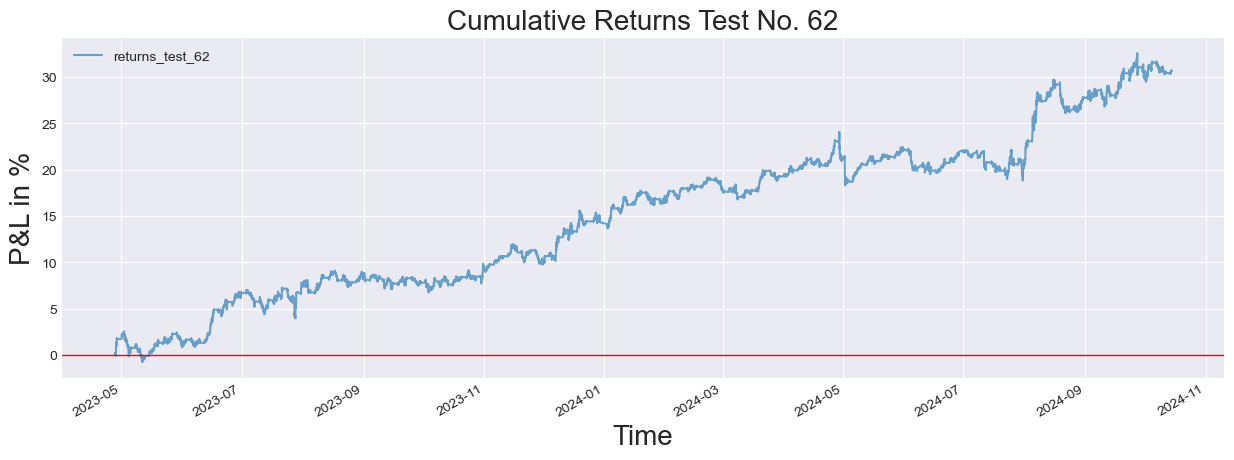

In [263]:
display.plot_test_returns(returns_df["returns_test_62"], name="Test No. 62")

**Strategy Drawdown from Model 62**

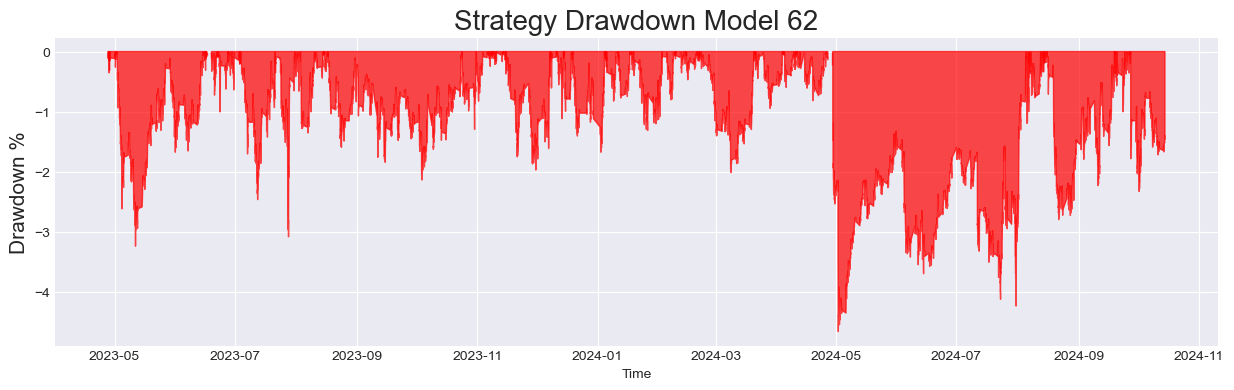

Max Drawdown: -4.66%


In [266]:
display.plot_drawdown(returns_df["returns_test_62"], name="Model 62")

**Forecast Accuracy Analysis for Model_62**

**Metric:** returns/drawdown
- Predicted vs. Real Positions

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
1    4690
0    4410
Name: count, dtype: int64

Model has an accuracy of: 51.54%


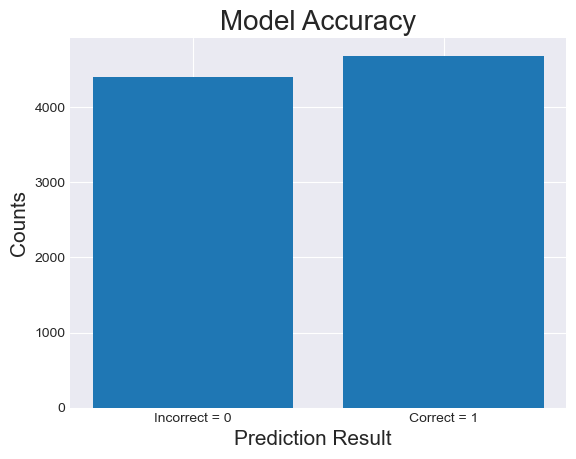

,real_position,pred_position,accuracy
0,1.0,1.0,1
1,1.0,1.0,1
2,-1.0,1.0,0
3,-1.0,1.0,0
4,1.0,1.0,1


In [272]:
backtest.compute_model_accuracy(np.sign(y_test[5:].values), positions_df["position_test_12"])

**Creating Confusion Matrix for Model 62**

In [277]:
from sklearn.metrics import confusion_matrix

In [300]:
# Confusion Matrix
confusion_matrix(np.sign(y_test[5:].values), positions_df["position_test_62"])

array([[ 891,    0, 3483],
       [   1,    0,   35],
       [ 894,    0, 3796]], dtype=int64)

In [302]:
# Counting the distribution of predicted positions for model 62
pd.DataFrame(positions_df["position_test_62"]).value_counts()

position_test_62
 1.0                7314
-1.0                1786
Name: count, dtype: int64

### Note:

After analyzing the confusion matrix for **model 62**, I observed that it predicted mostly positive (up/long) positions. This indicates that the model is not biased towards a balanced outcome and might lacks proper generalization.